# Ressources

In [1]:
import pandas as pd
import numpy as np
import missingno
from IPython.display import display, Image
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pycaret.classification import *

# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
import re

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import plotly.figure_factory as ff
import gc

# Garbage collection is to release memory when the object is no longer in use. This system destroys the unused object and reuses its memory slot for new objects. You can imagine this as a recycling system in computers.

import shap

import time
from contextlib import contextmanager

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from rich.console import Console

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fonctions
## Data

In [2]:
def comparaisons_colonnes(df1:pd.DataFrame, df2:pd.DataFrame):
    """Compare les colonnes de deux DF, et renvoient celles qui ne sont pas présentes dans les deux fichiers.

    Parameters
    -----------
    df1: :class:`DataFrame`

    df2: :class:`DataFrame`

            
    Return
    ----------
    Deux listes avec la différence dans le DataFrame 1 puis le DataFrame 2
    
    Exemples
    ----------
    list_1 = list(df_2015.columns)
    
    list_2 = list(df_2016.columns)

    dif1, dif2 = comparaisons_colonnes(df1, df2)
    """
    
    list_1 = list(df1.columns)
    list_2 = list(df2.columns)
    # Un set est un ensemble de clefs non ordonnées et non redondant où l'on peut savoir
    # si un élément est présent sans avoir à parcourir toute la liste (une sorte de dictionnaire où les valeurs seraient ignorées, seules les clefs comptent).
    dif_list_1_list_2 = list(set(list_1) - set(list_2))
    dif_list_2_list_1 = list(set(list_2) - set(list_1))
    nb_dif_list1_list_2 = len(dif_list_1_list_2)
    nb_dif_list2_list1 = len(dif_list_2_list_1)
    print(f'Colonnes présentes dans le df1, absentes dans le df2 ({nb_dif_list1_list_2}) : {dif_list_1_list_2}')
    print(f'Colonnes présentes dans le df2, absentes dans le df1 ({nb_dif_list2_list1}) : {dif_list_2_list_1}')
    

    
def identification_colonne_binaire(df, var_ignore=None):
    
    df_identif = df.copy()
    if var_ignore != None:
        df_identif.drop([var_ignore], axis=1, inplace=True)
    nb_cols = df_identif.shape[1]
    col_binaire_name = []
    col_binaire_number = []
    for i in range(0, nb_cols):
        len_colonne = len(df_identif.iloc[:,i].value_counts())
        
        if len_colonne == 2:
            col_binaire_name.append(df_identif.iloc[:,i].name)
            col_binaire_number.append(i)
            
            
            
    print(f'Colonnes binaires : {col_binaire_name}')
    print(f'Nombres : {len(col_binaire_number)}')
    
    return col_binaire_name, col_binaire_number


def identification_colonne_categorique(df, var_ignore=None, nb_valeurs_unique=2):
    
    df_identif = df.copy()
    if var_ignore != None:
        df_identif.drop([var_ignore], axis=1, inplace=True)
    nb_cols = df_identif.shape[1]
    col_binaire_name = []
    col_binaire_number = []
    for i in range(0, nb_cols):
        len_colonne = len(df_identif.iloc[:,i].value_counts())
        
        if nb_valeurs_unique == 2:
            if len_colonne == nb_valeurs_unique:
                col_binaire_name.append(df_identif.iloc[:,i].name)
                col_binaire_number.append(i)
                df_identif.iloc[:,i] = df_identif.iloc[:,i].astype('object')
        else:
            if len_colonne <= nb_valeurs_unique:
                col_binaire_name.append(df_identif.iloc[:,i].name)
                col_binaire_number.append(i)
                df_identif.iloc[:,i] = df_identif.iloc[:,i].astype('object')
            
            
    if var_ignore != None:
        df_identif[var_ignore] = df[var_ignore]
            
            
            
    print(f'Colonnes binaires : {col_binaire_name}')
    print(f'Nombres : {len(col_binaire_number)}')
    
    return df_identif

### Corrélation

In [3]:
def correlation_independante_et_dependante(df:pd.DataFrame, colonne:str, title:str):
        
        """Corrélation entre des variables indépendantes avec une variable dépendante.
        Renvoie une heatmap en une seule colonne

    Parameters
    -----------
    df: :class:`DataFrame`
            Le DataFrame
    colonne: :class:`str`
            La variable dépendante, où on va juger les corrélations des autres variables
    title: :class:`str`
            Titre du graphique
            
    Return
    ----------
    Graphique
    """
        
        f, ax = plt.subplots(figsize=(11, 20))

        heatmap = sns.heatmap(df.corr()[[colonne]].sort_values(by=colonne, ascending=False), annot=True)
        
        heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline

def cv_smoke(df):
        clf = LGBMClassifier(
            # nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            device="cpu",
            n_jobs=-1)
    
        X = df.drop(['TARGET'], axis=1)
        y = df['TARGET']

        # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, random_state=0)   
        
        steps = [('over', SMOTE()), ('model', clf)]
        pip = Pipeline(steps=steps)
        
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
        scores = cross_val_score(pip, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
        
        print('Mean ROC AUC: %.3f' % np.mean(scores))
        


Selection des features -> Imputer -> Smote

In [5]:
df_importance = pd.read_csv('feature_importance.csv')
data_results = pd.read_csv('data_featured.csv')


# Selection features

In [6]:
cols = df_importance.sort_values(by=["importance"], ascending=False)['feature'].unique()[:20]
data_features = data_results[cols]

data_features['SK_ID_CURR'] = data_results['SK_ID_CURR']
data_features['TARGET'] = data_results['TARGET']

data_features

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_ID_PUBLISH,APPROVED_CNT_PAYMENT_MEAN,DAYS_EMPLOYED_PERC,...,ACTIVE_DAYS_CREDIT_MAX,DAYS_REGISTRATION,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,AMT_CREDIT,REGION_POPULATION_RELATIVE,INSTAL_DPD_MEAN,AMT_GOODS_PRICE,PREV_CNT_PAYMENT_MEAN,SK_ID_CURR,TARGET
0,0.060749,0.083037,0.139376,0.262949,9461,24700.5,-637.0,-2120,24.000000,0.067329,...,-103.0,-3648.0,780.0,406597.5,0.018801,0.000000,351000.0,24.000000,100002,1.0
1,0.027598,0.311267,NaN,0.622246,16765,35698.5,-1188.0,-291,10.000000,0.070862,...,-606.0,-1186.0,1216.0,1293502.5,0.003541,0.000000,1129500.0,10.000000,100003,0.0
2,0.050000,NaN,0.729567,0.555912,19046,6750.0,-225.0,-2531,4.000000,0.011814,...,NaN,-4260.0,NaN,135000.0,0.010032,0.000000,135000.0,4.000000,100004,0.0
3,0.094941,NaN,NaN,0.650442,19005,29686.5,-3039.0,-2437,18.000000,0.159905,...,NaN,-9833.0,NaN,312682.5,0.008019,0.000000,297000.0,23.000000,100006,0.0
4,0.042623,NaN,NaN,0.322738,19932,21865.5,-3038.0,-3458,20.666667,0.152418,...,NaN,-4311.0,NaN,513000.0,0.028663,0.954545,513000.0,20.666667,100007,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,0.042354,NaN,0.643026,0.648575,19970,17473.5,-5169.0,-3399,24.000000,0.258838,...,-303.0,-9094.0,495.0,412560.0,0.002042,0.000000,270000.0,24.000000,456221,NaN
356247,0.051267,NaN,NaN,0.684596,11186,31909.5,-1149.0,-3003,17.500000,0.102718,...,NaN,-3015.0,NaN,622413.0,0.035792,0.520548,495000.0,17.500000,456222,NaN
356248,0.105414,0.733503,0.283712,0.632770,15922,33205.5,-3037.0,-1504,11.000000,0.190742,...,-229.0,-2681.0,NaN,315000.0,0.026392,0.000000,315000.0,11.000000,456223,NaN
356249,0.055840,0.373090,0.595456,0.445701,13968,25128.0,-2731.0,-1364,17.000000,0.195518,...,-890.0,-1461.0,-2.0,450000.0,0.018850,0.034483,450000.0,14.500000,456224,NaN


In [7]:
data_features_train = data_features[data_features['TARGET'].notnull()] # Target présent
data_features_train.drop(['SK_ID_CURR'], axis=1, inplace=True)
data_features_test = data_features[data_features['TARGET'].isnull()] # Target NA

print(f"Train : {data_features_train.shape}")
print(f"Test : {data_features_test.shape}")

Train : (307507, 21)
Test : (48744, 22)


## avec SimpleImputer + Smoke

In [8]:
test_py_only = setup(data_features_train, target="TARGET", use_gpu=True, memory="D:/Pycaret/", session_id=6643, fix_imbalance=True)

,Description,Value
0,Session id,6643
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(307507, 21)"
4,Transformed data shape,"(488007, 21)"
5,Transformed train set shape,"(395754, 21)"
6,Transformed test set shape,"(92253, 21)"
7,Numeric features,20
8,Rows with missing values,74.9%
9,Preprocess,True


In [9]:
best = compare_models(sort="AUC", include=['lightgbm'], turbo=False) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8839,0.6911,0.1495,0.2029,0.1721,0.1112,0.1127,2.2330


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

## Avec IterativeImputer + smoke

On fait le iterativeImputer séparemment car ma version de scikit-learn est trop avancé

In [10]:
# On impute les nan

# DATA LEAKAGE !
imp_mean = IterativeImputer(missing_values = np.nan, random_state=0)


columns = data_features_train.columns

data_features_train_imp = pd.DataFrame(imp_mean.fit_transform(data_features_train[columns]))
data_features_train_imp.columns = columns
data_features_train_imp

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_ID_PUBLISH,APPROVED_CNT_PAYMENT_MEAN,DAYS_EMPLOYED_PERC,...,INSTAL_DAYS_ENTRY_PAYMENT_MAX,ACTIVE_DAYS_CREDIT_MAX,DAYS_REGISTRATION,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,AMT_CREDIT,REGION_POPULATION_RELATIVE,INSTAL_DPD_MEAN,AMT_GOODS_PRICE,PREV_CNT_PAYMENT_MEAN,TARGET
0,0.060749,0.083037,0.139376,0.262949,9461.0,24700.5,-637.000000,-2120.0,24.000000,0.067329,...,-49.0,-103.000000,-3648.0,780.000000,406597.5,0.018801,0.000000,351000.0,24.000000,1.0
1,0.027598,0.311267,0.488320,0.622246,16765.0,35698.5,-1188.000000,-291.0,10.000000,0.070862,...,-544.0,-606.000000,-1186.0,1216.000000,1293502.5,0.003541,0.000000,1129500.0,10.000000,0.0
2,0.050000,0.626991,0.729567,0.555912,19046.0,6750.0,-225.000000,-2531.0,4.000000,0.011814,...,-727.0,-579.073561,-4260.0,993.733383,135000.0,0.010032,0.000000,135000.0,4.000000,0.0
3,0.094941,0.636959,0.551730,0.650442,19005.0,29686.5,-3039.000000,-2437.0,18.000000,0.159905,...,-12.0,-490.328882,-9833.0,1021.362780,312682.5,0.008019,0.000000,297000.0,23.000000,0.0
4,0.042623,0.651679,0.527636,0.322738,19932.0,21865.5,-3038.000000,-3458.0,20.666667,0.152418,...,-14.0,-451.796368,-4311.0,645.038537,513000.0,0.028663,0.954545,513000.0,20.666667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.108198,0.145570,0.435259,0.681632,9327.0,27558.0,-236.000000,-1982.0,8.000000,0.025303,...,-38.0,-407.626378,-8456.0,2092.538867,254700.0,0.032561,0.000000,225000.0,8.000000,0.0
307503,0.044524,0.625901,0.556075,0.115992,20775.0,12001.5,-3281.845766,-4090.0,6.000000,0.160619,...,-2327.0,-417.070519,-4388.0,114.466348,269550.0,0.025164,0.500000,225000.0,6.000000,0.0
307504,0.044239,0.744026,0.218859,0.535722,14966.0,29979.0,-7921.000000,-5150.0,5.000000,0.529266,...,-1738.0,-713.000000,-6737.0,387.000000,677664.0,0.005002,0.642857,585000.0,5.000000,0.0
307505,0.054592,0.374378,0.661024,0.514163,11961.0,20205.0,-4786.000000,-931.0,15.000000,0.400134,...,-18.0,-523.505348,-2562.0,1549.269537,370107.0,0.005313,0.000000,319500.0,15.000000,1.0


In [11]:
test7 = setup(data_features_train_imp, target="TARGET", use_gpu=True, memory="D:/Pycaret/", session_id=6643, fix_imbalance=True, imputation_type=None)

,Description,Value
0,Session id,6643
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(307507, 21)"
4,Transformed data shape,"(488007, 21)"
5,Transformed train set shape,"(395754, 21)"
6,Transformed test set shape,"(92253, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,None


In [12]:
pip = get_config('pipeline')
pip

Pipeline(memory='D:/Pycaret/',
         steps=[('balance',
                 TransformerWrapper(exclude=None, include=None, transformer=FixImbalancer(estimator=SMOTE(k_neighbors=5, n_jobs=None, random_state=None, sampling_strategy='auto'))))],
         verbose=False)

In [13]:
best = compare_models(sort="AUC", include=['lightgbm', 'catboost', 'xgboost', 'lda'], turbo=False) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9157,0.8494,0.3442,0.4700,0.3973,0.3532,0.3582,1.2350
lightgbm,Light Gradient Boosting Machine,0.9013,0.8316,0.3789,0.3869,0.3827,0.3291,0.3292,1.9460
catboost,CatBoost Classifier,0.8506,0.8178,0.5565,0.2834,0.3756,0.3008,0.3229,7.2460
lda,Linear Discriminant Analysis,0.7260,0.7899,0.7149,0.1870,0.2964,0.1931,0.2606,0.9630


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

In [14]:
xgb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9173,0.8483,0.3613,0.4834,0.4136,0.3701,0.3746
1,0.9141,0.8536,0.3308,0.4556,0.3833,0.3384,0.3434
2,0.9164,0.8515,0.3446,0.4754,0.3996,0.3559,0.3612
3,0.9163,0.8426,0.3562,0.4758,0.4074,0.3634,0.3678
4,0.9142,0.8540,0.3581,0.4594,0.4025,0.3570,0.3602
5,0.9147,0.8585,0.3460,0.4620,0.3957,0.3508,0.3550
6,0.9166,0.8430,0.3414,0.4763,0.3977,0.3542,0.3599
7,0.9183,0.8561,0.3539,0.4916,0.4115,0.3689,0.3746
8,0.9171,0.8478,0.3412,0.4813,0.3993,0.3562,0.3623


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
tuned_xgb = tune_model(xgb, n_iter=50, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8954,0.8714,0.6122,0.4029,0.4860,0.4305,0.4422
1,0.8964,0.8809,0.6087,0.4055,0.4868,0.4317,0.4427
2,0.8933,0.8774,0.6122,0.3960,0.4809,0.4245,0.4370
3,0.8978,0.8697,0.6018,0.4097,0.4875,0.4331,0.4430
4,0.8948,0.8820,0.6212,0.4019,0.4880,0.4324,0.4451
5,0.8951,0.8865,0.6298,0.4038,0.4921,0.4367,0.4502
6,0.8952,0.8719,0.6005,0.4005,0.4805,0.4249,0.4356
7,0.8938,0.8745,0.6139,0.3977,0.4827,0.4265,0.4390
8,0.8970,0.8774,0.6064,0.4073,0.4873,0.4325,0.4431


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


---------------------------

Le reste est du bonus : on ne prend pas en compte dans la restitution finale

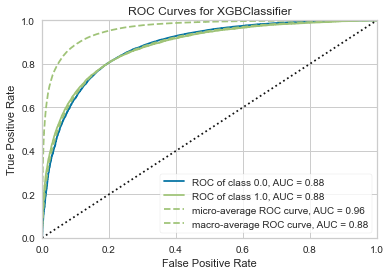

In [16]:
plot_model(tuned_xgb, plot='auc')

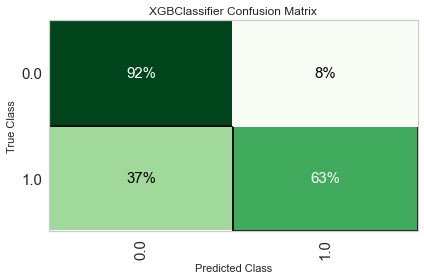

In [17]:
plot_model(tuned_xgb, plot='confusion_matrix', plot_kwargs = {'percent' : True})

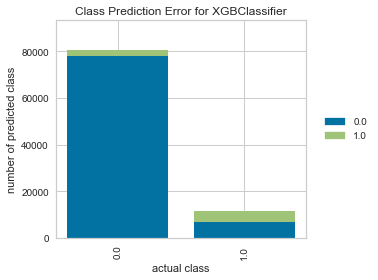

In [18]:
plot_model(tuned_xgb, plot='error')

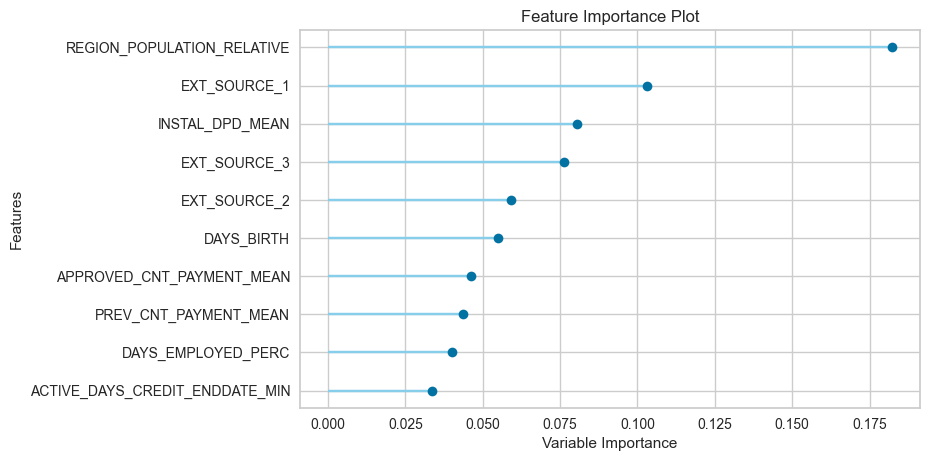

In [19]:
plot_model(tuned_xgb, plot='feature')

In [20]:
save_model(tuned_xgb, 'pycaret/selectImportance/pycaret_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory='D:/Pycaret/',
          steps=[('balance',
                  TransformerWrapper(exclude=None, include=None, transformer=FixImbalancer(estimator=SMOTE(k_neighbors=5, n_jobs=None, random_state=None, sampling_strategy='auto')))),
                 ['trained_model',
                  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=0.7, earl...
                                gamma=0, gpu_id=0, grow_policy='depthwise',
                                importance_type=None, interaction_constraints='',
                                learning_rate=0.1, max_bin=256,
                                max_cat_to_onehot=4, max_delta_step=0,
                                max_depth=10, max_leaves=0, min_child_weight=3,
                                missing=nan, monotone_constraints='()',
                                n_estimators=290, n_jobs=-

In [21]:
create_api(tuned_xgb, 'pycaret/selectImportance/pycaret_api')


    API sucessfully created. This function only creates a POST API, it doesn't run it automatically.
    To run your API, please run this command --> !python pycaret/selectImportance/pycaret_api.py
        


In [22]:
# !python pycaret/selectImportance/pycaret_api.py